## Analyze Accuracy per class

In [21]:
import os
import warnings

import pandas as pd
from PIL import Image, ImageDraw, ImageFont

warnings.filterwarnings("ignore")

### topex-printer (RGB)

In [22]:
# ds_source = "../data/topex-printer-12/train/rgb"
# ds_target = "../data/topex-printer-12/test/rgb"
ds_source = "../data/topex-printer/train"
ds_target = "../data/topex-printer/test"
df_classacc = pd.read_csv(
    "../data/eval-data/STL-topex--uda--swinv2--ch-uda_cdan-mcc_adamw1e-5_warmupcalr_augmix_classacc.csv"
)
df_confmat = pd.read_csv(
    "../data/eval-data/STL-topex--uda--swinv2--ch-uda_cdan-mcc_adamw1e-5_warmupcalr_augmix_confmat.csv"
)

In [23]:
display(df_classacc.head())
display(df_classacc.describe())
display(df_confmat.head())

,class_name,acc
0,03011-205,0.247619
1,03026-206,0.719008
2,03059-08,0.016949
3,03288-05x20,0.979167
4,1015_du,0.075472


,acc
count,102.000000
mean,0.759587
std,0.284989
min,0.000000
25%,0.676353
50%,0.880291
75%,0.972222
max,1.000000


,Actual,Predicted,nPredictions
0,03011-205,03011-205,26
1,03011-205,03026-206,59
2,03011-205,03059-08,0
3,03011-205,03288-05x20,0
4,03011-205,1015_du,0


In [24]:
def count_files(dir):
    return len([name for name in os.listdir(dir) if os.path.isfile(os.path.join(dir, name))])

----------------------------------------
gtm-0815-005


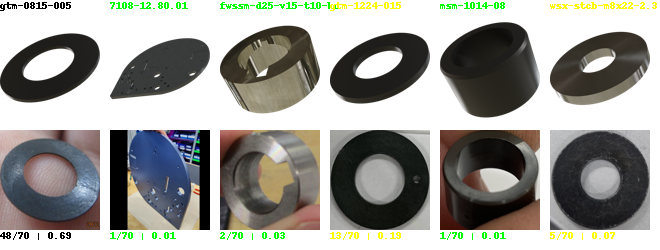

----------------------------------------
wsx-stcb-m8x22-2.3


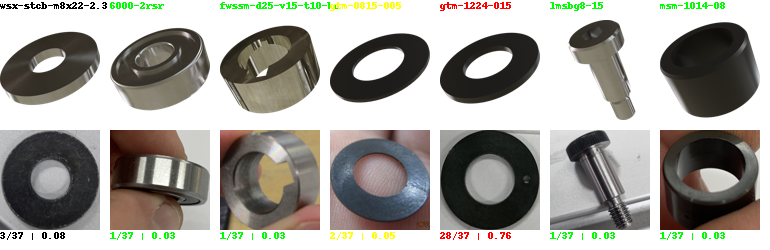

----------------------------------------
gtm-1224-015


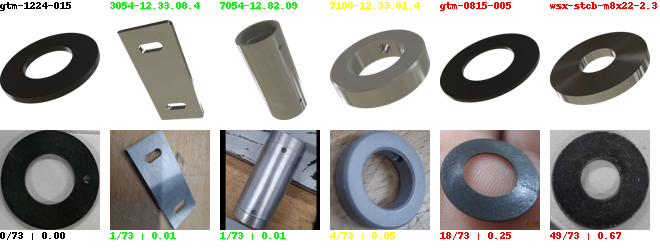

In [31]:
def show_class_confusion(classes=[], imsize=100, spacer=10, textsize=20):
    df_sorted = df_classacc.sort_values(by="acc", ascending=False)
    for cls in df_sorted["class_name"]:
        n_source = count_files(f"{ds_source}/{cls}")
        n_target = count_files(f"{ds_target}/{cls}")
        acc_target = df_sorted[df_sorted["class_name"] == cls]["acc"].values[0]

        cls_conf = df_confmat[
            (df_confmat["Actual"] == cls) & (df_confmat["nPredictions"] > 0) & (df_confmat["Predicted"] != cls)
        ]
        n_imgs = len(cls_conf) + 1
        img_conf_grid = Image.new("RGBA", ((imsize + spacer) * n_imgs, imsize * 2 + spacer + textsize * 2))

        img_source = Image.open(f"{ds_source}/{cls}/train_{cls}_0001_0007.png").resize((imsize, imsize))
        img_target = Image.open(f"{ds_target}/{cls}/test_{cls}_0001.png").resize((imsize, imsize))
        img_conf_grid.paste(img_source, (0, textsize))
        img_conf_grid.paste(img_target, (0, textsize + imsize + spacer))

        n_target_pred = df_confmat[(df_confmat["Actual"] == cls) & (df_confmat["Predicted"] == cls)][
            "nPredictions"
        ].values[0]
        draw = ImageDraw.Draw(img_conf_grid)
        font = ImageFont.load_default()
        text = f"{n_target_pred}/{n_target} | {acc_target:.2f}"
        text_color = (0, 0, 0)
        text_position = (0, textsize + imsize * 2 + spacer)
        text_width, text_height = draw.textsize(text, font=font)
        draw.text(text_position, text, font=font, fill=text_color)
        text = cls
        text_position = (0, 0)
        draw.text(text_position, text, font=font, fill=text_color)

        for i, pred_cls in enumerate(cls_conf["Predicted"]):
            conf_n_pred = cls_conf[(cls_conf["Predicted"] == pred_cls)]["nPredictions"].values[0]
            conf_ratio = conf_n_pred / n_target
            img_conf_source = Image.open(f"{ds_source}/{pred_cls}/train_{pred_cls}_0001_0007.png").resize((imsize, imsize))
            img_conf_grid.paste(img_conf_source, ((i + 1) * (imsize + spacer), textsize))
            img_conf_target = Image.open(f"{ds_target}/{pred_cls}/test_{pred_cls}_0001.png").resize((imsize, imsize))
            img_conf_grid.paste(img_conf_target, ((i + 1) * (imsize + spacer), textsize + imsize + spacer))

            text = f"{conf_n_pred}/{n_target} | {conf_ratio:.2f}"
            if conf_ratio < 0.05:
                text_color = (0, 255, 0)
            elif conf_ratio < 0.2:
                text_color = (255, 255, 0)
            else:
                text_color = (255, 0, 0)
            text_width, text_height = draw.textsize(text, font=font)
            text_position = ((i + 1) * (imsize + spacer), textsize + imsize * 2 + spacer)
            draw.text(text_position, text, font=font, fill=text_color)
            text = pred_cls
            text_position = ((i + 1) * (imsize + spacer), 0)
            draw.text(text_position, text, font=font, fill=text_color)
        if cls in classes or len(classes) == 0:
            print("----------------------------------------")
            print(f"{cls}")
            display(img_conf_grid)


kugellager = ["6002-2rs1", "6003-2rs1", "6000-2rsr", "kms03116", "b678zz", "w_63800-2z", "61803_rs"]  # Kugellager -> Ähnlichkeiten/Unterschiede feststellen
plättchen = ["gtm-1224-015", "wsx-stcb-m8x22-2.3", "gtm-0815-005"]  # Plättchen -> Ähnlichkeiten/Unterschiede untereinander feststellen
gewinde = ["03059-08", "03011-205", "03026-206"]  # Gewinde -> Gewinde reinrendern
federn = ["z-066sx_einbaul.29", "z-108i_einbaul.47,5"]  # Federn
ringe_plastik_schwarz = ["gsm-1012-10", "msm-1014-08", "gsm-1416-10"]  # Ringe Plastik (Schwarz)
falsches_material = [
    "97-50-121-12-verschluß",
    "97-50-121-12-bügel",
    "97-50-121-12-befestigung",
    "414768_30",
    "97-50-121-12-schließe",
    "jsm-12_14-06",
    "wsx-stcb-m8x22-2.3",
    "7108-12.80.03",
]  # Falsches Material
CLASSES = kugellager + plättchen + gewinde + federn + ringe_plastik_schwarz + falsches_material
show_class_confusion(kugellager)
# show_class_confusion()